Мне интересно изучать данные, строить между ними зависимости и находить аномалии. Еще мне интересно учиться программировать. Помогает держать мозги в тонусе. Код, который вы увидите ниже, не идеальный, но я и не программист.

Я хочу поделиться своим опытом, как это можно делать, используя Jupyterlab (технология, которая позволяет общаться с компьютером на его языке без сложностей, связанных с установкой IDE, компиляторов и погружения в процесс программирования глубоко). В моем случае я использую язык программирования python, он удобный в освоении и его легко читать.

Это не введение в программирование на python или подробная инструкция, совсем незнакомым с прораммированием людям будет немного сложно, но я специально все разбил на небольшие кусочки и не стал писать сложные контрукции, чтобы все немного упростить.

Для манипулирования данными я буду использовать pandas - это очень популярная библиотека для работы с данными в памяти. На примерах ниже довольно просто разобраться в принципах работы этой штуки.

Мне так же было бы интересно, если ко мне подключатся другие исследователи, которым интересна эта тема. И мы могли бы вместе дополнить докумен, собрать побольше данных и сделать полноценный анализ.

Эта первая статья - notebook - то есть документ, который получается на выходе в Jupyter. Я выложу ее в github () и если вам итересно - пожалуйста, добавляйте туда свой код!

Мне интересно было построить всякие данные про депутатов и все такое. У сайта думы есть API, через которые данные можно забирать. Чтобы это делать, нужно сходить на их сайт и получить Token. http://api.duma.gov.ru/pages/dokumentatsiya

Теперь, когда у вас есть ключ (я использую два, это конфигурация для приложений), можно начинать.

Для начала нужно наимпортировать всякие штуки, которые мы будем использовать

In [8]:
import pandas as pd
import json
from urllib.request import urlopen
import sqlite3
from pathlib import Path

In [35]:
from beakerx import *
beakerx.pandas_display_default()

Нужно добавить логирование. И небольшой хак (не очень правильный, скорее всего, чтобы работало). Я сделал это уже во второй итерации, чтобы сделать за тем, как забираются документы с сервера. Там ниже я описывал, как часть данных с сервера через API не отдавались, и я связался с ними. И они сказали, что исправили ошибку. Но как-то так, что не совсем наверняка. Поэтому без логирования не обошлось. Но это пригодится. 

In [9]:
import logging, sys
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(filename='harvester.log', level=logging.DEBUG)
logging.info("Logger Prepared")

Теперь запомним tokens, которые получаем при регистрации, вообще это должно выглядеть примерно как-то так:

In [10]:
token='qwertyuiop'
app_token='qwertyuiop'

Но так как у каждого пользователя должны быть свои ключи, я сохранил их в файлики (token & app_token) и добавил их в .gitignore, чтобы они не попали в хранилище:

In [11]:
token=open('token', 'r').read().rstrip('\n')
app_token=open('app_token', 'r').read().rstrip('\n')

Теперь можно проверить, что работает. Лишних пробелов и переносов строк быть не должно.

In [12]:
print("token: <{}>, app_token: <{}>".format(token, app_token))

token: <83b6a9f29fd9debaecbb3bf8328ab9b4c9ca0bd7>, app_token: <app1c3c2901c16ffb7a7fe062186b3cd795ff01f89d>


Ниже будем хранить ссылки на нужные нам запросы, они начинаются с `u`, так проще запомнить

In [13]:
uDeputiesList='http://api.duma.gov.ru/api/:token/deputies.json?app_token=:app_token'
uDeputyInfo='http://api.duma.gov.ru/api/:token/deputy.json?id=:id&app_token=:app_token'
uLawAreas='http://api.duma.gov.ru/api/:token/classes.json?app_token=:app_token'

Чтобы не прогонять цикл загрузок и очисток данных, их можно загружать в базу данных. Для простоты, можно пользоваться `sqlite3` - с ним просто работать и не нужно ничего устанавливать. Я не стал писать обертки для базы, потому что там кода немного и без них.

In [14]:
database_name = 'database.db'

Теперь создадим несколько простых функций, который помогут с рутиной. Последний - кеширует запросы к API, чтобы не нужно было каждый раз их дергать при написании кода и отладки. Я не знаю, какие у этого API ограничения на количество и частоту запросов, возможно это все не так важно.

In [23]:
def prep(url):
    """Replaces token placeholders in strings"""
    url = url.replace(':token',token).replace(':app_token', app_token)
    return url

def grab(url):
    """Returns string from url retrieval output"""
    try:
        return urlopen(prep(url)).read().decode()
    except Exception as e:
        logging.error("url: {}, message: {}".format(prep(url), e))
        return "null"
    
def cache(url, name):
    """Saves json result into cache/ folder"""
    with open('cache/{}'.format(name), 'w') as f:
        f.write(grab(url))

Я использую папку `cache` для кеширования документов, и папку`cache/deputyinfo` для кеширования документов, в которых живет информация про депутатов. Их можно создать сразу.

In [8]:
%%sh
mkdir cache
mkdir cache/deputyinfo

mkdir: cache: File exists
mkdir: cache/deputyinfo: File exists


Начнем с загрузки списка депутатов. В этом списке есть вложенная структура `factions`, в ней история перемещения депутатаа между франциями. Возможно, это интересная статистическая информация. Сначала закешируем сам документ с данными.

In [9]:
cache(uDeputiesList, 'deputies.json')

Теперь можно этот документ обработать. Создадим фрейм с данными про депутатов, сохраним его в базу, следующим шагом пробежимся через список фракций и из них посмотрим еще один фрем, привяжем записи к идентификатору депутата. Тоже сохраним в базу. На выходе получится две структуры - deputies & fractions.

In [16]:
#load deputies into DB
file = open('deputies.json', 'r').read()
deputies = pd.read_json(file)
deputies = deputies.drop('factions', axis=1)
with sqlite3.connect(database_name) as db:
    deputies.to_sql(name='deputies', con=db, if_exists='replace')
db.close();

#load fractions into DB
_factions = []
file = open('deputies.json', 'r').read()
json_data = json.loads(file)
for item in json_data:
    if 'factions' in item:
        for faction in item['factions']:
            _factions.append({'deputy':item['id'],
                              'id':faction['id'],
                              'name':faction['name'],
                              'start': faction['startDate'],
                              'end': faction['endDate']})
fractions = pd.DataFrame(_factions)
with sqlite3.connect(database_name) as db:
    fractions.to_sql(name='fractions', con=db, if_exists='replace')
db.close()

Теперь немного подобъем статистику. В несколько шагов.

Добавим колонку с количеством фракций, в которых депутат побывал,
Добавим колонку с саммой ранней датой, когда депутат стал депутатом,
Добавим колонку с самой поздней датой, когда он должен будет сложить полномочия.

Теперь можно перестроить колонки немного и привести их типы в порядок.

Сначала приведем типы данных в колонках в порядок. В принципе, это не очень важно, но так удобнее - не нужно все приводить к строкам при сравнении например. 

In [55]:
deputies['firstStart'] = pd.to_datetime(deputies['firstStart'])
deputies['lastEnd'] = pd.to_datetime(deputies['lastEnd'])
fractions['deputy'] = pd.to_numeric(fractions['deputy'])
fractions['id'] = pd.to_numeric(fractions['id'])
fractions['start'] = pd.to_datetime(fractions['start'])
fractions['end'] = pd.to_datetime(fractions['end'])

Теперь посчитаем некоторые штуки и добавим результат в виде колонок.

In [56]:
#count number of fractions per deputy
deputies['fractionsCount']=deputies['id'].apply(lambda x: fractions.loc[fractions['deputy']==x].shape[0])

#count earliest start
deputies['firstStart']=deputies['id'].apply(lambda x: fractions.loc[fractions['deputy']==x]['start'].min())

#count latest end
deputies['lastEnd']=deputies['id'].apply(lambda x: fractions.loc[fractions['deputy']==x]['end'].max())

#reorder columns
deputies = deputies[['id', 'name', 'position', 'firstStart', 'lastEnd', 'fractionsCount', 'isCurrent']]

Можно посмотреть, что получилось.

In [36]:
deputies.sample()

,id,name,position,firstStart,lastEnd,fractionsCount,isCurrent,lawCount,region
2266,99109936,Сысоев Александр Митрофанович,Депутат ГД,2003-12-07,2011-05-03,4,False,0,None


In [37]:
fractions.sample()

,deputy,end,id,name,start
1640,99102425,2005-07-11,72100024,"Фракция Всероссийской политической партии ""ЕДИ...",2004-04-16


Теперь можно собрать больше данных про депутатов. Они по большей части бесполезные, но там есть количество законов, в продвижении которых принимал участие депутат и регион, который от представляет. Всего в базе 2к+ депутатов, поэтому для начала я закеширую ответы для каждого из них.

Я специально закомментировал сррочку, которая вызывает функцию, поэтому что это небыстрый процесс и его нет смысла повторять часто. Если бы данные менялись часто, то их нужно было бы выбирать в несколько потоков, но в идеале я соберу их один раз, поэтому я не стал заморачиваться.

А теперь когда я делаю это втретий раз, я понял, что зря не заморочился. Последний раз это заняло 30 минут почти на 3000 документов.

In [24]:
def loadDeputyInfoFiles(id_list):
    for item in id_list:
        cache(prep(uDeputyInfo.replace(':id', str(item))), 'deputyinfo/{}.json'.format(str(item)))
%time loadDeputyInfoFiles(deputies['id'].tolist())

CPU times: user 4.24 s, sys: 2.78 s, total: 7.02 s
Wall time: 29min 9s


Очень много полученных докуметов - пустые - там просто `null` в теле ответа. Поэтому лишные файлы нужно удалить.

In [26]:
%%bash
find ./cache/deputyinfo/ -size -5c -delete

Теперь можно загрузить данные из этих файлов. Начнем с количества законов.

In [87]:
def collectLawcountFromCachedFiles(id):
    file = Path('./cache/deputyinfo/{}.json'.format(id))
    if file.exists():
        return json.loads(open(file,'r').read())['lawcount']
    return 0

deputies['lawCount'] = deputies['id'].apply(collectLawcountFromCachedFiles)

То же самое можно сделать с регионами (я удаляю скобочки). Я знаю, что есть более изящные способы это делать через регулярные выражения и все такое, но мне лень было возиться для двух символов.

In [88]:
def collectRegionsFromCachedFiles(id):
    file = Path('./cache/deputyinfo/{}.json'.format(id))
    if file.exists():
        region = json.loads(open(file,'r').read())['factionRegion']
        if region != None:
            return region.replace('(','').replace(')','')
    return None

deputies['region'] = deputies['id'].apply(collectRegionsFromCachedFiles)

Теперь все это добро про депутатов можно свалить в файл. Я выбираю только активных депутатов и сортирую вывод по количеству законов.

In [89]:
def dumpActiveDeputiesToCSV():
    deputies.loc[(deputies['isCurrent']==True) & (deputies['position'] == ('Депутат ГД'))].sort_values(by='lawCount', ascending=False).to_csv('_deputies.csv', index=False)
dumpActiveDeputiesToCSV()

А теперь начинается интересное. Если внимательно посмотреть на табличку, то выходит, что половина депутатов не участвует в разработки законов. Оказалось, что это не так - регионов у них тоже нет. А если пойти на сайт думы и поискать через сайт - то и законы и регионы отдаются. А через API отдаются эти данные далеко не для всех. 

Я написал письмо webmaster@duma.gov.ru - это был единственный адрес для контактов. Но это больше похоже на спортлото. Скорее всего, мне никто не ответит. Конечно, можно использовать scrapy и забирать недостающие данные через веб-страницы, но я пока попробую дождаться ответа. Во-первых, это может быть не единственным багов, а во-вторых, возиться с граберрами страниц лично мне не очень интересно.

Я собирался начинать строить графики про количество законов по депутатам, регионам и вот это все, но делать это на неправильных данных было бы глупо. 

А пока - пауза.

А да. Еще вот можно начинать складировать информацию про сами законы. Начать можно с простого.

In [19]:
cache(prep(uLawAreas), 'lawareas.json')

__UPDATE__

Я не дождался ответа по почте, и написал через веб-сайт. Оттуда ответили буквально через день или два и сообщили, что починили ошибку. Я сейчас проверяю. Возможно ошибку починили, но теперь появилась другая, я уже поменял код сверху, чтобы ее обойти. Теперь есть более полноценные данные по всем активным депутатам. Можно вернуться к этим данным и что-нибудь посчитать.

Начнем с подсчета длительности нахождения депутата у депутатского руля.

In [142]:
def calculateDeputyDuration(id):
    w = fractions.loc[fractions['deputy'] == id]
    days = 0
    for index, item in w.iterrows():
        if item['end'] > datetime.today():
            days+=(datetime.today()-item['start']).days
        else:
            days+=(item['end']-item['start']).days
    return days

In [143]:
deputies['daysInPower'] = deputies['id'].apply(lambda x:calculateDeputyDuration(x))

In [144]:
dumpActiveDeputiesToCSV()

Наконец-то можно посмотреть на какие-нибудь графики и поискать интересности. Мне интересно посмотреть, как количество проведенного у депутатского руля времени влияет на количество законов, в продвижении которых участвовал депутат. Рисовать графики довольно просто и я для этого есть много библиотек. Я буду использовать `lantern`. Сначала загрузим библиокету.

In [92]:
import lantern as l

Matplotlib loaded
Cufflinks loaded


Loading BokehJS ...

Plot.ly loaded
Qgrid loaded


Теперь создадим график. Я думаю, по коду все довольно хорошо понятно.

In [204]:
currentDumaDeputies = deputies.loc[(deputies['isCurrent']==True) & (deputies['position'] == 'Депутат ГД')]

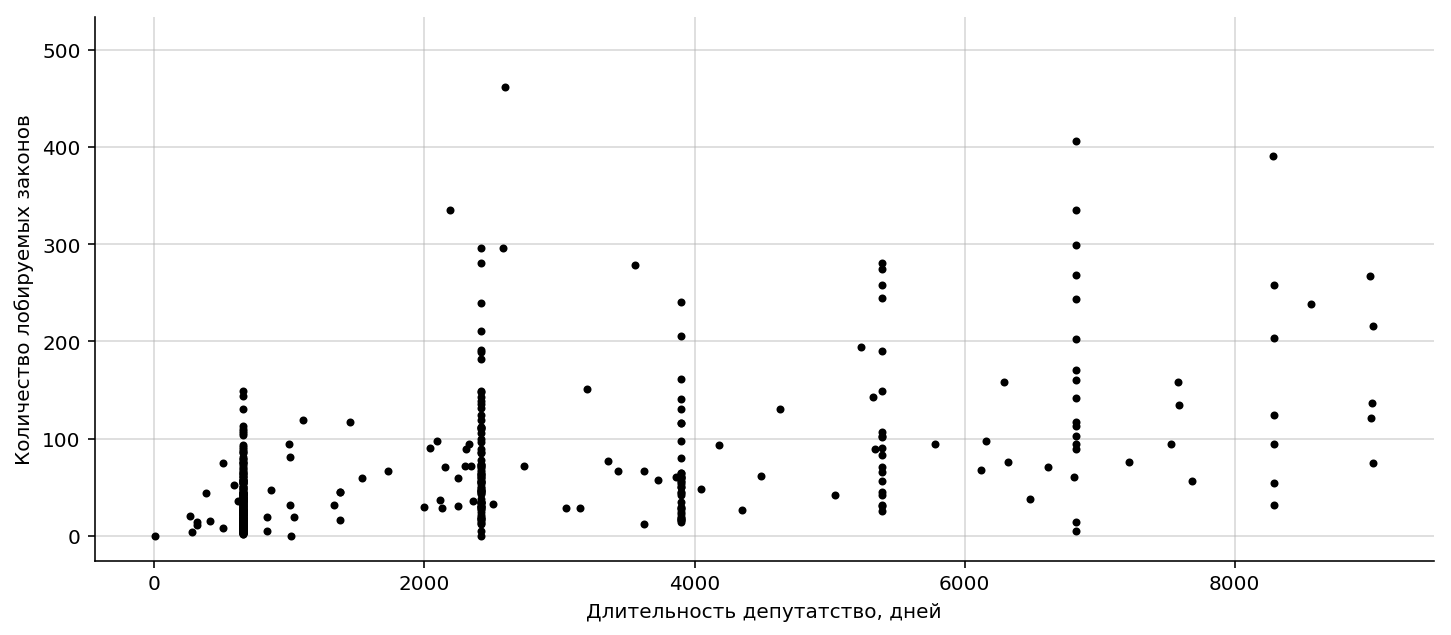

In [205]:
f = l.figure('matplotlib')
f.scatter(data=currentDumaDeputies[['daysInPower','lawCount']], x='daysInPower', y='lawCount', color='black')
f.show(xlabel='Длительность депутатство, дней', ylabel='Количество лобируемых законов', legend=None)

Вот тут начинается наука - нужно строить интересные тезисы и как-то их доказывать. Тут интересно было бы услышать размышления публики, что в этих данных можно интересного найти, наверняка что-то есть. Чтобы не рисовать всякие графики каждый раз отдельно, можно написать простую функцию.

In [207]:
def plotScatterXY(title, data, x, y):
    f = l.figure()
    f.scatter(data=data[[x,y]],x=y,y=y)
    f.show(title=title, legend=False)

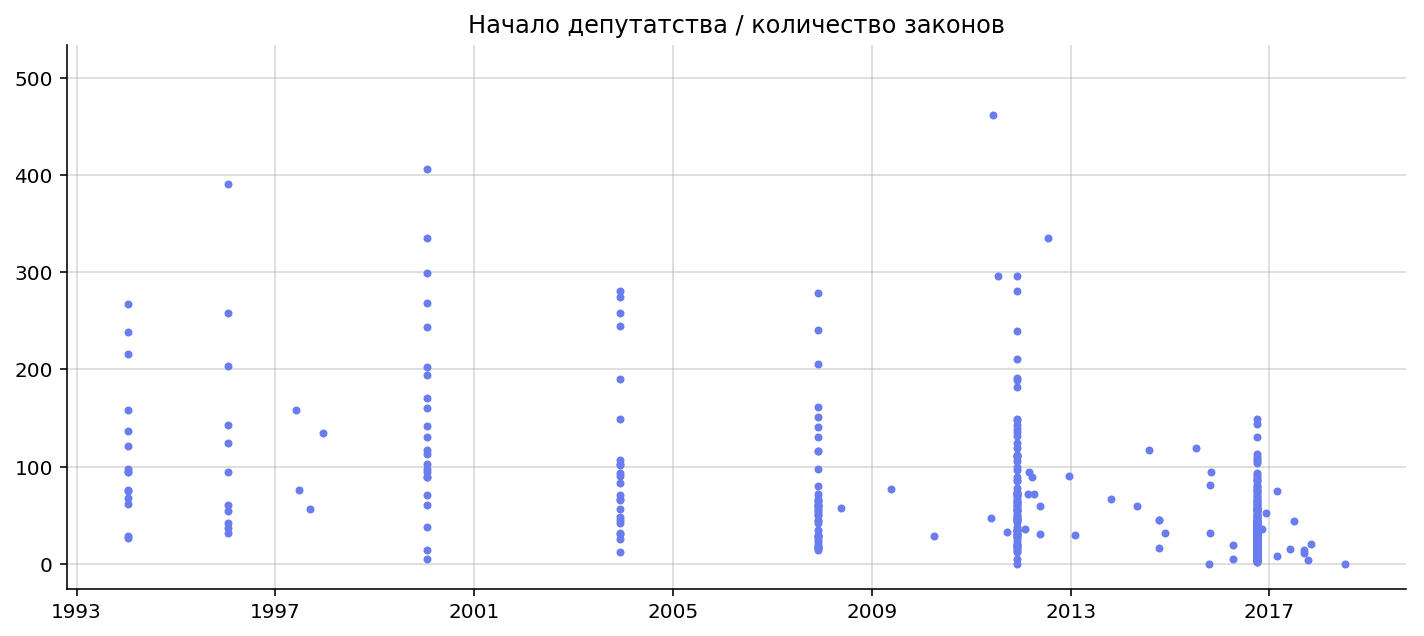

In [208]:
plotScatterXY('Начало депутатства / количество законов', currentDumaDeputies, 'firstStart','lawCount')

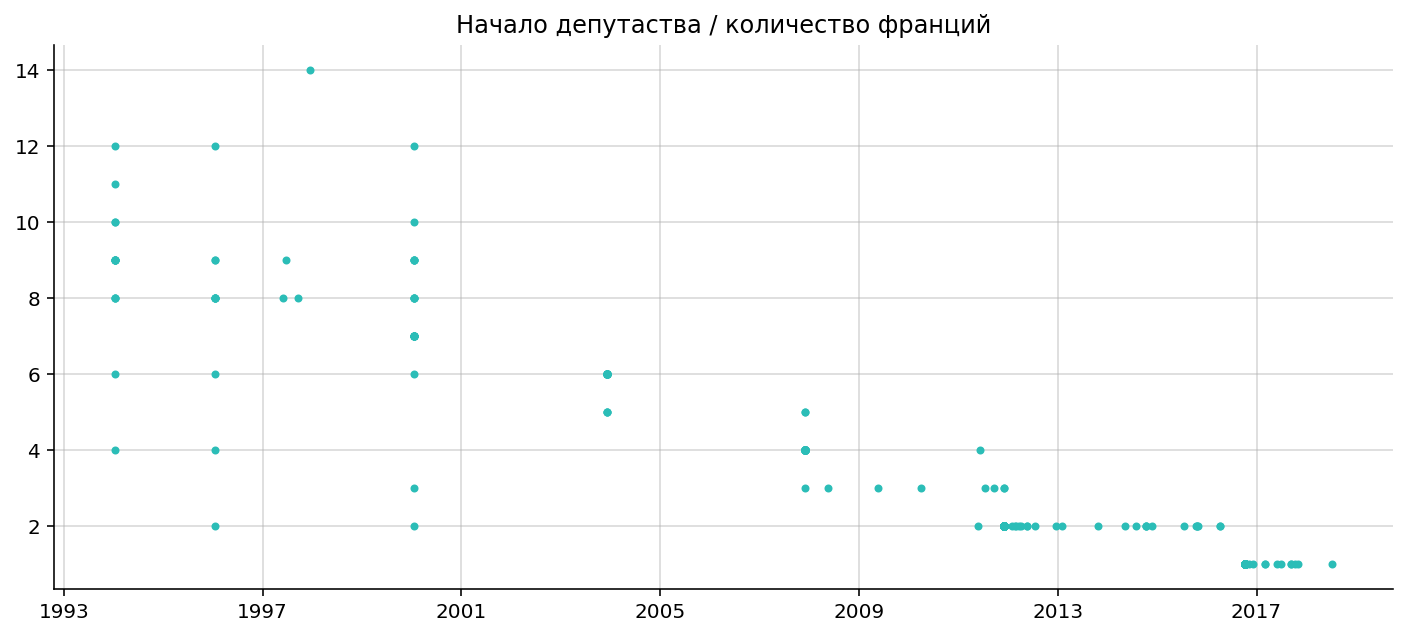

In [211]:
plotScatterXY('Начало депутаства / количество франций', currentDumaDeputies, 'firstStart','fractionsCount')

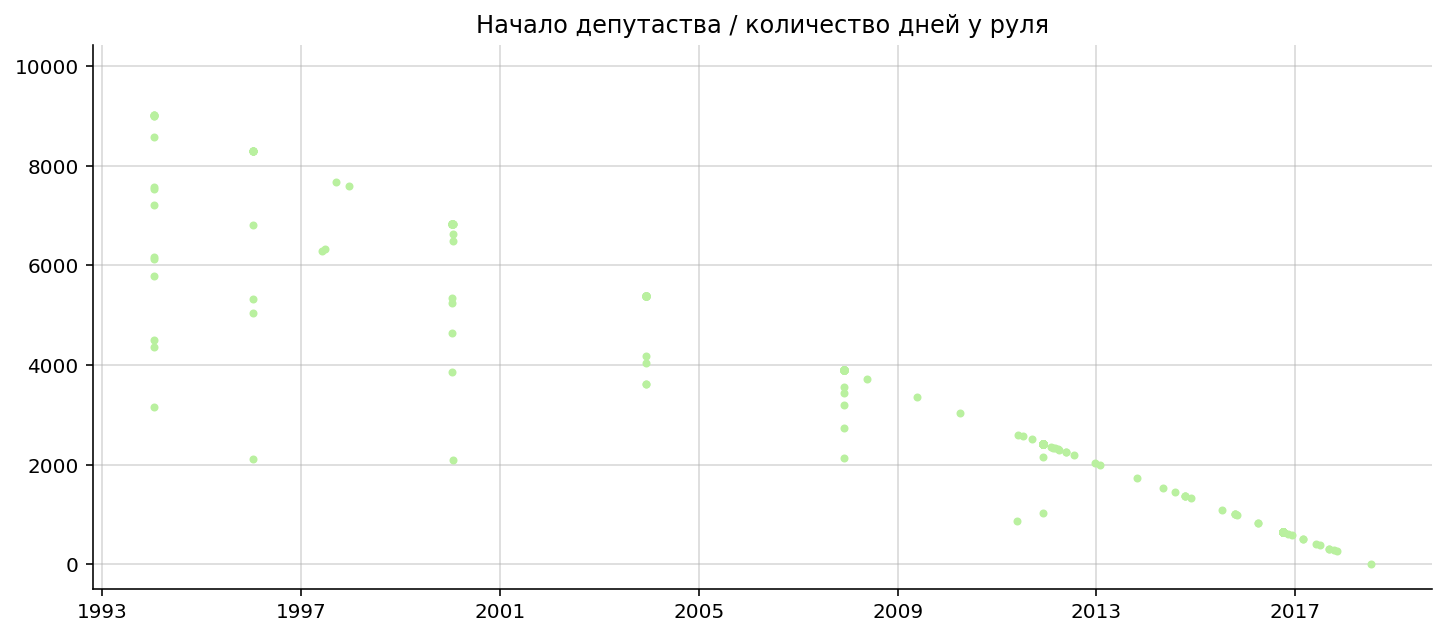

In [212]:
plotScatterXY('Начало депутаства / количество дней у руля', currentDumaDeputies, 'firstStart','daysInPower')